[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

/tmp/ipykernel_3896718/3250776187.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [2]:
local_path = 'Data/Mannheim_Quad/' #path of the file
df = pd.read_csv(local_path + 'cnct.csv',header=None) #Connectivity matrix
n_ele = (df.to_numpy().shape[0]+1)//4 #number of elements
cnct = np.zeros((n_ele,4),dtype=int)
for i in range(n_ele):
    cnct[i,:] = df.to_numpy().ravel()[i*4:i*4+4]

df2 = pd.read_csv(local_path + 'crd_x.csv',header=None)
df3 = pd.read_csv(local_path + 'crd_y.csv',header=None)
df4 = pd.read_csv(local_path + 'crd_z.csv',header=None)
x_nodes = df2.to_numpy().ravel()
y_nodes = df3.to_numpy().ravel()
z_nodes = df4.to_numpy().ravel()
df5 = pd.read_csv(local_path + 'bc_node.csv',header=None)
bc_nodes =df5.to_numpy().ravel()
n_node = x_nodes.shape[0] #number of nodes
#Normalize the coordinates
xs = x_nodes-min(x_nodes)
ys = y_nodes-min(y_nodes)
x_span = max(xs) - min(xs)
y_span = max(ys)-min(ys)

zs = 0.001*np.array([1.16650095, 3.62250162, 0.63325483, 0.77655229, 1.31265331,
       1.68669962, 1.3108091 , 0.70937376, 0.75285485, 0.75147257,
       3.72966479, 3.33904017, 3.2852944 , 3.68587899, 3.94246337,
       3.28325979, 0.40413206, 0.50044157, 0.66623939, 1.16997263,
       1.38378168, 0.75926339, 0.93162776, 1.10626873, 0.62429206,
       0.48496525, 0.52765893, 0.37263336, 0.48602284, 0.37234998,
       0.62823902, 1.11117905, 1.51770931, 1.83650319, 1.33985457,
       1.35554889, 1.85021962, 2.24377223, 2.54619062, 2.07800999,
       2.11718138, 2.57550883, 2.93027954, 3.18962572, 2.76603404,
       2.84413549, 3.24312633, 3.53590915, 3.72819718, 3.35961348,
       3.49551447, 3.81602071, 4.02678719, 4.13139956, 3.82381225,
       4.03920535, 4.26486464, 4.37663276, 4.37626722, 4.13169936,
       4.4501666 , 4.56733296, 4.56619375, 4.44693168, 4.26387636,
       4.70967206, 4.70757647, 4.58283105, 4.3342407 , 4.20815888,
       4.80494237, 4.67590867, 4.42017962, 4.03530249, 3.95912661,
       4.72901498, 4.46859995, 4.07778906, 3.5529028 , 3.51744802,
       4.48074946, 4.08768435, 3.56068427, 2.89479812, 2.88902319,
       4.06484793, 3.54068514, 2.87879948, 2.07288733, 2.08401889,
       3.49174221, 2.84016068, 2.0462311 , 1.10224328, 1.11583318,
       2.77720325, 2.00296643, 1.08024217, 0.        , 0.        ,
       1.94152254, 1.04909232, 0.        , 1.00793791, 0.        ,
       0.95605401, 0.        , 0.89348999, 0.        , 0.82272567,
       0.        , 0.        , 0.        , 0.        , 0.81904075,
       0.        , 0.88612716, 0.        , 0.94339533, 0.        ,
       0.98836827, 0.        , 1.02138229, 0.        , 1.0441208 ,
       0.        , 1.05915698, 0.        , 1.0697462 , 0.        ,
       1.07933857, 0.        , 1.09038619, 0.        , 1.10285587,
       0.        , 1.11533725, 0.        , 1.12617231, 0.        ,
       1.13396352, 0.        , 1.13765824, 0.        , 1.13645844,
       0.        , 1.12969115, 0.        , 1.11668911, 0.        ,
       1.09668975, 0.        , 1.06874455, 0.        , 1.03162437,
       0.        , 0.98370166, 0.        , 0.92278552, 0.        ,
       0.8458956 , 0.        , 0.74908755, 0.        , 0.        ,
       0.        , 0.        , 0.31018502, 0.        , 0.27900664,
       0.        , 0.26406092, 0.        , 0.25720765, 0.        ,
       0.25454901, 0.        , 0.34355399, 0.33977273, 0.25720616,
       0.25454852, 0.        , 0.        , 0.26405546, 0.        ,
       0.27898629, 0.        , 0.31010909, 0.        , 0.        ,
       0.        , 0.        , 0.73926761, 0.        , 0.82625715,
       0.        , 0.88838222, 0.        , 0.92854509, 0.        ,
       0.94861997, 0.        , 0.94959274, 0.        , 0.93174535,
       0.        , 0.89478731, 0.        , 0.83800111, 0.        ,
       0.76058996, 0.        , 0.66272225, 0.        , 0.54849585,
       0.        , 0.43296673, 0.        , 0.35046502, 0.        ,
       0.30178512, 0.        , 0.27574564, 0.        , 0.26253666,
       0.        , 0.25603213, 0.        , 0.25288289, 0.        ,
       0.25137332, 0.        , 0.25065481, 0.        , 0.25031623,
       0.        , 0.25016191, 0.        , 0.25010216, 0.        ,
       0.33356257, 0.33347789, 0.2501623 , 0.25010229, 0.        ,
       0.        , 0.25031766, 0.        , 0.25066013, 0.        ,
       0.25139318, 0.        , 0.25295702, 0.        , 0.25630877,
       0.        , 0.2635691 , 0.        , 0.27959876, 0.        ,
       0.31616516, 0.        , 0.        , 0.        , 0.        ,
       0.85335037, 0.        , 0.9271843 , 0.        , 0.98567187,
       0.        , 1.03159921, 0.        , 1.06683462, 0.        ,
       1.09269767, 0.        , 1.11010191, 0.        , 1.11962301,
       0.        , 1.12153544, 0.        , 0.        , 2.08018801,
       2.0614203 , 2.86153714, 2.02718748, 2.81159037, 3.45338297,
       2.73758722, 3.35870024, 3.84691358, 3.23025049, 3.69500195,
       4.03788288, 3.49829417, 3.81782768, 4.02775699, 3.54071001,
       3.73095788, 3.82470701, 3.36399083, 3.4456919 , 3.44427856,
       2.98312452, 2.98132997, 2.90968577, 2.42156437, 2.36509893,
       2.2519674 , 1.71051151, 1.63205997, 1.51071209, 1.74967538,
       1.75133899, 2.42348652, 2.37125154, 1.71593466, 2.91532302,
       2.77625852, 2.26359529, 3.19732386, 2.94166939, 2.56212524,
       3.25006398, 2.85291565, 2.59049783, 3.06361642, 2.5063387 ,
       2.34081772, 2.6370167 , 1.9072237 , 1.81723731, 1.97637492,
       1.70304828, 1.56028714, 2.13430156, 1.87893689, 2.26643806,
       1.56455958, 1.86752561, 2.09746833, 1.37496982, 1.52996051,
       1.64273611, 1.17513652, 0.37199411, 0.41426316, 0.35170221,
       0.34204231, 0.33745945, 0.3352889 , 0.33426301, 0.33378153,
       0.37511394, 0.42243341, 0.35336274, 1.54504268, 1.69487817,
       2.33128772, 1.81373007, 2.50228919, 3.05995243, 2.63751988,
       3.23120388, 3.69629176, 3.36438479, 3.85257665, 4.21297763,
       3.96998575, 4.34329526, 4.58882451, 4.43472649, 4.68549745,
       4.80828762, 4.7434845 , 4.86637193, 4.86133005, 4.88571889,
       4.87832424, 4.74355458, 4.85602679, 4.71946298, 4.45649229,
       4.65511161, 4.39424211, 4.00786328, 4.29083459, 3.91395419,
       3.4115931 , 3.77885914, 3.29680607, 2.68742611, 3.14267926,
       2.56750593, 1.85993863, 2.41331304, 1.75612149, 2.21988508,
       1.6285136 , 1.98100542, 1.47789117, 2.6900416 , 2.37287915,
       1.97566399, 2.67813891, 2.20451392, 1.6154059 , 1.4718966 ,
       2.38218022, 1.73241923, 2.51428766, 1.82202881, 2.60613857,
       1.8863734 , 2.663854  , 1.92927728, 2.6954535 , 1.95609425,
       2.71222798, 1.97382258, 2.72970938, 1.99055522, 2.76409325,
       2.01268367, 2.8082731 , 2.03903337, 2.85285754, 2.06565416,
       2.89103718, 2.0887218 , 2.91853121, 2.10535688, 2.93267785,
       2.11354433, 2.93165093, 2.11181769, 2.91391715, 2.09895038,
       2.87787065, 2.07370887, 2.82157199, 2.03465868, 2.74253519,
       1.97999742, 1.9073846 , 3.46455678, 3.53561793, 4.05284764,
       3.58052997, 4.10439374, 4.49059894, 4.12693174, 4.51312437,
       4.76480301, 4.50349713, 4.75021762, 4.86670971, 4.69919397,
       4.80820889, 4.79294354, 4.70732165, 4.68576022, 4.54713114,
       4.52897789, 4.39015148, 4.14134424, 4.17648598, 3.93886508,
       3.59666539, 3.67429806, 3.3595914 , 2.94307299, 3.05766251,
       3.33621146, 2.91083341, 3.53538519, 3.08013637, 3.66266864,
       3.19337255, 3.72465555, 3.25787997, 3.72862452, 3.28297111,
       4.08278241, 4.05432575, 4.35488708, 4.29676603, 4.1333173 ,
       4.47786733, 4.27938581, 3.95185894, 3.84798732, 3.47979906,
       3.41044158, 4.03359689, 3.53737151, 4.09065742, 3.57838626,
       4.1220178 , 3.60031824, 3.60152439, 4.46196205, 4.38783302,
       4.60972066, 4.55893015, 4.31440305, 4.0305946 , 3.89585762])
xs = xs
ys = ys

xs_const = xs
ys_const = ys

In [3]:
#Properties, design nodes, load;
t = 0.1
E = 1e10
nu = 0.3 
design_nodes = []
non_design_nodes = []
for i in range(n_node):
    if i in bc_nodes:
      non_design_nodes.append(i)
      
    else:
      design_nodes.append(i)
      zs[i] = np.random.uniform(0.5,0.51)#random_z
design_nodes = np.asarray(design_nodes)
load = 5000



Disjoin a quad into 4-edges

In [4]:
raw_cnct_bar = []
raw_cnct = df.to_numpy().ravel()
for i in range(n_ele):
  raw_cnct_bar.append([raw_cnct[i*4],raw_cnct[i*4+1]])
  raw_cnct_bar.append([raw_cnct[i*4+1],raw_cnct[i*4+2]])
  raw_cnct_bar.append([raw_cnct[i*4+2],raw_cnct[i*4+3]])
  raw_cnct_bar.append([raw_cnct[i*4+3],raw_cnct[i*4]])

raw_cnct_bar = np.asarray(raw_cnct_bar) # with duplication

cnct_bar = []
for i in range(n_node):
  temp_list = []
  rows_i = np.argwhere(raw_cnct_bar==i)[:,0]
  cols_i = np.argwhere(raw_cnct_bar==i)[:,1]
  for j in range(rows_i.shape[0]):
    if cols_i[j] == 0:
      if raw_cnct_bar[rows_i[j],1] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],1])
    else:
      if raw_cnct_bar[rows_i[j],0] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],0])
  raw_cnct_bar = np.delete(raw_cnct_bar,rows_i,0)
  cnct_bar.extend(temp_list)
cnct_bar = np.asarray(cnct_bar,dtype=int)
cnct_network = cnct_bar.reshape(cnct_bar.shape[0]//2,2)

n_ele_bar = cnct_network.shape[0]
x_ele = np.zeros((n_ele_bar,2)) #x of the elements
y_ele = np.zeros((n_ele_bar,2))
z_ele = np.zeros((n_ele_bar,2))

In [5]:
design_nodes.shape

(412,)

In [6]:
len(non_design_nodes)

98

The initial structure, visualization

In [7]:
n_ele

457

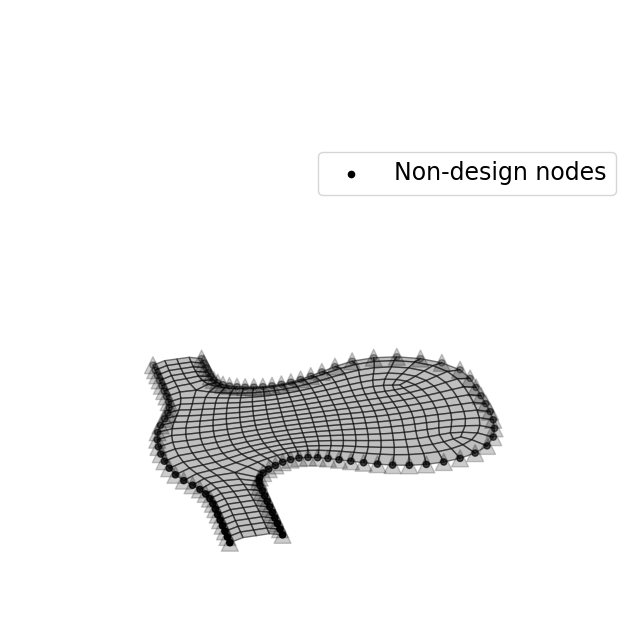

In [11]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs[cnct_network[i,0]],zs[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
#  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')
all_corners = []

for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.axis('off')
plt.show()


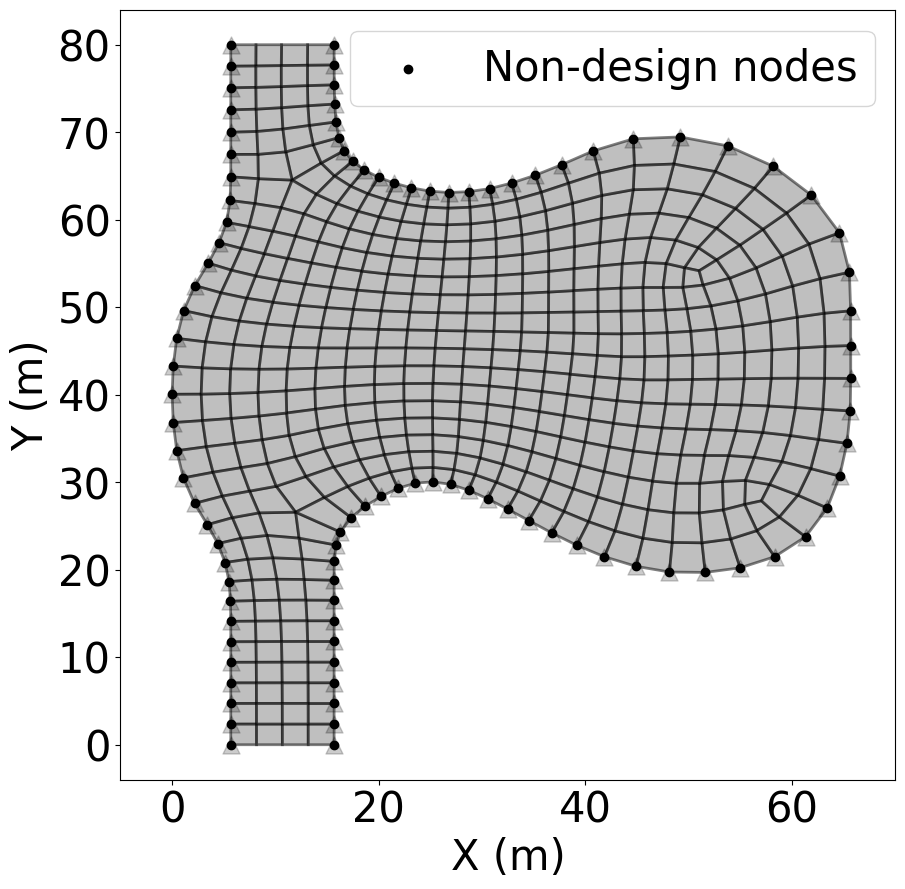

In [12]:

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim(-5,70)
#plt.ylim(-5,30)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    this_poly.set_alpha(0.5)
    this_poly.set_facecolor('grey')
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

plt.legend(fontsize=30)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

# Direct optimization w/o any filter

## Create FEA model

In [13]:
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,1,1])
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

# SSO model based on FEA model

In [14]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [22]:
%timeit sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

160 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

(Array(913518.71151552, dtype=float64),
 Array([ 1.01467339e+04, -5.28295846e+04,  8.29177385e+02, -2.93124583e+03,
        -2.66073456e+03,  5.63442034e+02,  6.47060584e+03,  7.61501830e+03,
         6.55718815e+03,  9.90058753e+03,  2.93955392e+04,  1.86006952e+04,
        -5.89938349e+03, -6.99351245e+04, -7.03265373e+03, -2.49304137e+04,
        -8.21223044e+01, -6.34109772e+01, -1.41898857e+02, -4.37259342e+03,
         3.21375160e+03,  3.49707446e+03,  6.01623990e+02, -2.63032798e+03,
        -2.63761033e+02, -4.63083875e+02, -2.14413099e+02, -9.56779902e+01,
        -4.25166657e+02, -8.87868493e+01, -1.06930265e+03, -3.15725087e+03,
        -7.83109497e+03, -1.03159400e+04,  5.67425337e+01,  3.05257513e+03,
        -1.61391003e+04, -2.10910844e+04, -1.01526001e+04, -5.12506100e+03,
        -1.84578290e+04, -2.33369007e+04,  1.26045703e+04, -2.69103817e+04,
         7.49013439e+03, -1.86856412e+04, -6.09190673e+04, -1.29638380e+04,
         1.59241846e+04, -3.44784402e+04,  1.779

In [16]:
def objective(x,sso_model=sso_model):
    sso_model.update_nodeparameter(x) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    return C,sens #sens_params

In [17]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 913517.6867324249
Step 1, objective = 278165.7888367886
Step 2, objective = 121994.29756809957
Step 3, objective = 66051.55480611039
Step 4, objective = 37443.54696395688
Step 5, objective = 25606.324374194555
Step 6, objective = 18985.656487779368
Step 7, objective = 14489.272565276657
Step 8, objective = 11563.472127586592
Step 9, objective = 9554.682400624512
Step 10, objective = 8051.722157587415
Step 11, objective = 6864.201770720475
Step 12, objective = 5890.882679620718
Step 13, objective = 5074.136640225719
Step 14, objective = 4379.581455138786
Step 15, objective = 3821.812964783141
Step 16, objective = 3375.2488509855134
Step 17, objective = 3008.512860927946
Step 18, objective = 2701.9916493717083
Step 19, objective = 2442.382927284565
Step 20, objective = 2220.121599774197
Step 21, objective = 2028.0494140903597
Step 22, objective = 1860.68088951578
Step 23, objective = 1713.7426939174277
Step 24, objective = 1583.86723861054
Step 25, objective = 1468.37

# Draw the final structure

In [18]:
zs[design_nodes] = x_opt

In [19]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs[cnct_network[i,0]],zs[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,80)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
#  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

all_corners = []
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

### Without filter, the final structural geometry is not smooth. Also, the planarity of the shell elements are not preserved, leading to potential fictitious FEA results.

In [20]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))


Create filter mapping matrix $B_{ij}$

$z_i = B_{ij}p_j$

$\frac{df}{dp_j} = B_{ij}\frac{df}{dz_i}$

In [21]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,10)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [22]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] = x_opt
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

Filtered geometry of the previous (unfiltered) optimization

In [23]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs_filtered[cnct_network[i,0]],zs_filtered[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,80)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
#  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

all_corners = []
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Let us redo the optimization while including the filter

In [24]:
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,1,1])
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])
        zs[i] = np.random.uniform(0.5,0.51)#random_z

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [25]:
C_hist = []
def objective_filter(x,sso_model=sso_model):
    p = zs.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [26]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 77474.17136797289
Step 1, objective = 58660.962836482584
Step 2, objective = 45823.33538177122
Step 3, objective = 37614.30405552876
Step 4, objective = 31654.75992659162
Step 5, objective = 27271.05800520825
Step 6, objective = 23937.586044629363
Step 7, objective = 21689.204553930686
Step 8, objective = 19631.960592673313
Step 9, objective = 18493.54286723495
Step 10, objective = 17465.351416102745
Step 11, objective = 16624.807974209398
Step 12, objective = 15822.270708813194
Step 13, objective = 15115.19762650968
Step 14, objective = 14447.237268279194
Step 15, objective = 13840.577844360421
Step 16, objective = 13267.540266967775
Step 17, objective = 12738.279770145295
Step 18, objective = 12234.988105535187
Step 19, objective = 11767.214307240007
Step 20, objective = 11315.726416617981
Step 21, objective = 10898.342269573577
Step 22, objective = 10488.536666490629
Step 23, objective = 10126.067773638992
Step 24, objective = 9767.758391871499
Step 25, objective

In [27]:
zs[design_nodes] = x_opt
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

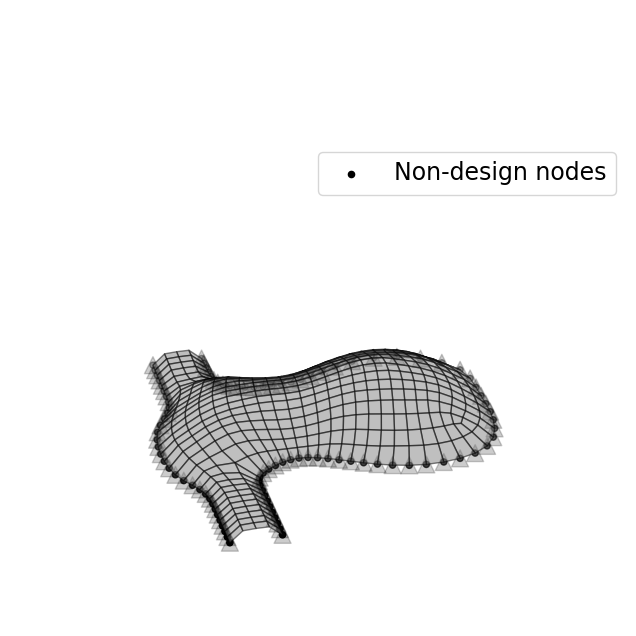

In [28]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs_filtered[cnct_network[i,0]],zs_filtered[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.axis('off')
plt.show()

The optimized structure is now smooth

In [52]:
np.array(C_hist).shape

(200,)

Text(0, 0.5, 'Total strain energy (KN$\\cdot$m)')

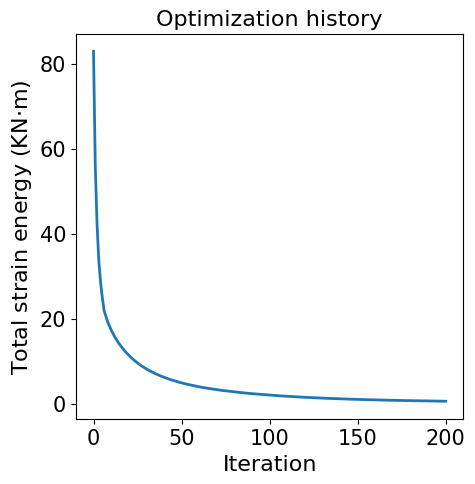

In [77]:


fig, ax = plt.subplots(figsize=(5,5))

plt.plot(np.linspace(0,200,200),np.array(C_hist)/1000,linewidth=2)
plt.xticks([0,50,100,150,200],fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (KN$\cdot$m)',fontsize=16)